In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

# load data
data = np.load("./heart_disease_data.npz") 

def ind_x_eq_val(x, val):
    return np.where(x==val)[0]

def count_x_eq_val(x, val):
    return len(ind_x_eq_val(x, val))/float(len(x))
    
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / sig / np.sqrt(2 * np.pi)

In [3]:
list(data.keys())

['chest_pain',
 'chest_pain_test',
 'sex',
 'cholesterol_test',
 'heart_disease_test',
 'heart_disease',
 'cholesterol',
 'sex_test']

### QUESTION (b) 
####  **Non-parametric model** Compute empirical pmf, derive the conditional pmf, and estimate the MAP decision by the mode of posterior distribution $p_{\tilde{h} \mid \tilde{s},\tilde{c}}$. (The MAP estimates should be $\tilde{h}=0 \text{ or } 1$)

In [4]:
# Estimate the pmf of H, i.e. P(H=0) and P(H=1)
H0_idx = ind_x_eq_val(data['heart_disease'], 0)
H1_idx = ind_x_eq_val(data['heart_disease'], 1)

P_H0 = count_x_eq_val(data['heart_disease'], 0)
P_H1 = count_x_eq_val(data['heart_disease'], 1)

# Estimate the conditional pmf of S given H, i.e. P(S|H=0) and P(S|H=1)
P_S_H0 = np.zeros(2)
P_S_H1 = np.zeros(2)

S_H0 = data['sex'][H0_idx]
S_H1 = data['sex'][H1_idx]
for ind_S in range(2):   
    P_S_H0[ind_S] = count_x_eq_val(S_H0, ind_S)
    P_S_H1[ind_S] = count_x_eq_val(S_H1, ind_S) 

# Estimate the conditional pmf of C given H, i.e. P(C|H=0) and P(C|H=1)
P_C_H0 = np.zeros(4)
P_C_H1 = np.zeros(4)


C_H0 = data['chest_pain'][H0_idx]
C_H1 = data['chest_pain'][H1_idx]
for ind_C in range(4):
    P_C_H0[ind_C] = count_x_eq_val(C_H0, ind_C)
    P_C_H1[ind_C] = count_x_eq_val(C_H1, ind_C)

# Calculate the MAP estimate
MAP_estimate_S_C = np.empty_like(data['heart_disease_test'])
for idx in range(MAP_estimate_S_C.size):
        sex_val = int(data['sex_test'][idx])
        chest_pain_val = int(data['chest_pain_test'][idx])
        
        P_H1_and_S_and_C = P_S_H1[sex_val] * P_C_H1[chest_pain_val] * P_H1
        P_H0_and_S_and_C = P_S_H0[sex_val] * P_C_H0[chest_pain_val] * P_H0
                
        P_H1_S_C = P_H1_and_S_and_C / (P_H1_and_S_and_C + P_H0_and_S_and_C)
        P_H0_S_C = P_H0_and_S_and_C / (P_H1_and_S_and_C + P_H0_and_S_and_C)
        
        MAP_estimate_S_C[idx] = int(P_H1_S_C >= P_H0_S_C)
        

# Calculate the error rate - i.e. the proportion of all predictions that were incorrect
error_rate_S_C = np.where(MAP_estimate_S_C != data['heart_disease_test'], 1, 0).sum() / MAP_estimate_S_C.size

print("Probability of error " + str(error_rate_S_C))

Probability of error 0.18


### QUESTION (d)
#### **Maximum likelihood estimates** Find the parameters of two normal distributions ($\tilde{x}|\tilde{h}=1$ and $\tilde{x}|\tilde{h}=0$) that maximize the likelihood functions.

In [5]:
H0_idx = ind_x_eq_val(data['heart_disease'], 0)
H1_idx = ind_x_eq_val(data['heart_disease'], 1)

X_H0 = data["cholesterol"][H0_idx]
X_H1 = data["cholesterol"][H1_idx]

X_H = [X_H0, X_H1]
## Estimate MLE of X given H
mean_X_H = np.zeros(2)
std_X_H = np.zeros(2)
mean_X_H[0]= X_H0.mean()
std_X_H[0] = X_H0.std()
mean_X_H[1]= X_H1.mean()
std_X_H[1] = X_H1.std()

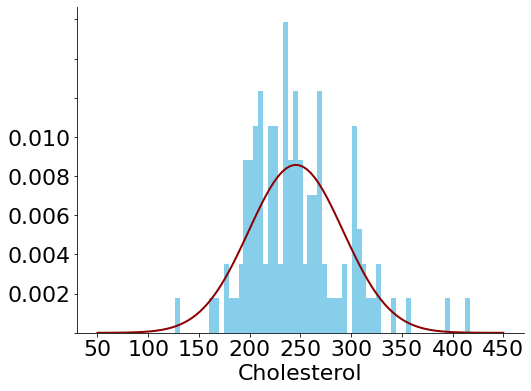

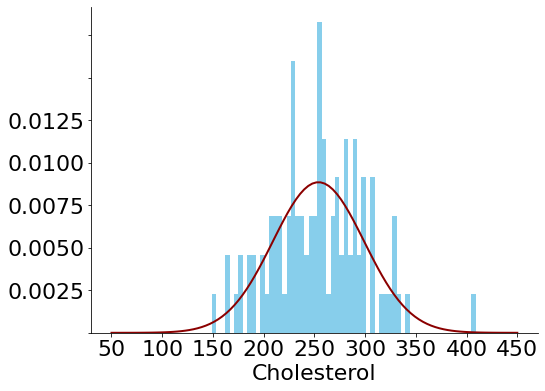

In [10]:
n_plot = 100
for i in range(2):
    plt.figure(figsize=(8, 6))  
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    yticks = ax.yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False) 
    plt.xticks(fontsize=22) 
    plt.yticks(fontsize=22) 
    plt.xlabel("Cholesterol", fontsize=22)  
    
    plt.hist(X_H[i], 60, edgecolor = "none", color="skyblue", density=True, stacked=True)
    
    plt.plot(np.linspace(50, 450, n_plot),gaussian(np.linspace(50, 450, n_plot), 
                     mean_X_H[i], std_X_H[i]), color="darkred", lw=2)

### QUESTION(e)

#### **MAP decision** compute posterior $p_{\tilde{h} \mid \tilde{s},\tilde{c}, \tilde{x}}$ and derive MAP

In [11]:
# Calculate the MAP estimate
MAP_estimate_S_C_X = np.empty_like(data["heart_disease_test"])
for idx in range(MAP_estimate_S_C_X.size):
    sex_val = int(data['sex_test'][idx])
    chest_pain_val = int(data['chest_pain_test'][idx])
    cholesterol_val = int(data['cholesterol_test'][idx])    
    
    P_H1_and_S_and_C_and_X = P_S_H1[sex_val] * P_C_H1[chest_pain_val] * gaussian(cholesterol_val, mean_X_H[1], std_X_H[1]) * P_H1
    P_H0_and_S_and_C_and_X = P_S_H0[sex_val] * P_C_H0[chest_pain_val] * gaussian(cholesterol_val, mean_X_H[0], std_X_H[0]) * P_H0
                
    P_H1_S_C_X = P_H1_and_S_and_C_and_X / (P_H1_and_S_and_C_and_X + P_H0_and_S_and_C_and_X)
    P_H0_S_C_X = P_H0_and_S_and_C_and_X / (P_H1_and_S_and_C_and_X + P_H0_and_S_and_C_and_X)
        
    MAP_estimate_S_C_X[idx] = int(P_H1_S_C_X > P_H0_S_C_X)

# # Calculate the error rate
error_rate_S_C_X = np.where(MAP_estimate_S_C_X != data['heart_disease_test'], 1, 0).sum() / MAP_estimate_S_C_X.size
print("Probability of error using cholesterol " + str(error_rate_S_C_X))

Probability of error using cholesterol 0.14
